# generate masks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
from scipy.io import readsav
from scipy import ndimage
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
# import math
import glob as glob
import seaborn as sns
import random

from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline

# PyMC 4.0 imports
import pymc as pm
import aesara.tensor as at 
import aesara
import arviz as az
import pymc.sampling_jax
import pytensor.tensor as pt
import pytensor

import sys
sys.path.append('../')

from scipy import stats

import os

from funciones.opencube2 import opencube2
from funciones.func4 import tilt,elong,MFLUX,barys,set_ranges
from funciones.modelcube import modelmag,modelmagf,modelmag2

def MODELT(name, data2, ranges, xc2, yc2, hem, apa, ind, sz2, sz1, nMagnetograms, scl, pixarea):
    with pm.Model() as modelB:
        # Stochastic variables
        #a = pm.Uniform('a', ranges['a'][0], 1.5*ranges['a'][1])
        a = pm.Normal('a', mu=np.mean(ranges['a']), sigma=1)
        axf = pm.Uniform('axf', ranges['axf'][0]/pixarea, 1.5*ranges['axf'][1]/pixarea)
#        R = pm.Uniform('R', 0.6*ranges['R'][0], ranges['R'][1])
        R = pm.Normal('R', mu=np.mean(ranges['R']), sigma=1)
        N01 = pm.Gamma('N01', alpha=2.5, beta=10)
        ts = pm.Categorical('ts', p=[0.5, 0.5])
        ymin=pm.Uniform('ymin',0,0.6)
        ymax=pm.Uniform('ymax',ymin,1)
#        da = pm.Uniform('da', 0, 1, shape=nMagnetograms)
        alp0 = pm.Uniform('alp0', ranges['alpha'][0], ranges['alpha'][1])
        alp1 = pm.Uniform('alp1', ranges['alpha'][0], ranges['alpha'][1])
#        alpha = pm.Uniform('alpha', ranges['alpha'][0], ranges['alpha'][1], shape=nMagnetograms)
        xc0 = pm.Normal('xc0', mu=np.mean(xc2), sigma=1)        
        yc0 = pm.Normal('yc0', mu=np.mean(yc2), sigma=1)          
        
        # Deterministic variables
        N0 = pm.Deterministic('N0', (2*ts-1)*N01)
        da = pm.Deterministic('da', np.arange(0,nMagnetograms,1)*(ymax-ymin)/(nMagnetograms-1)+ymin)
        alpha = pm.Deterministic('alpha', np.arange(0,nMagnetograms,1)*(alp1-alp0)/(nMagnetograms-1)+alp0)
        B0 = pm.Deterministic('B0', axf/(np.pi*a**2))
        xc = pm.Deterministic('xc', np.ones_like(xc2)*xc0)
        yc = pm.Deterministic('yc', np.ones_like(xc2)*yc0)
#        xc = pm.ConstantData('xc', value=np.array(xc2))
#        yc = pm.ConstantData('yc', value=np.array(yc2))                   
        sg = pm.ConstantData('sg', value=10)
        
    sx = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[1]
    sy = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[0]
    sz = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[2]

    def modelmagB(a=a, R=R, B0=B0, N0=N0, da=da, xc=xc, yc=yc, alpha=alpha):
        f = 0
        g = 0
        a0 = a
        R0 = R
        B00 = B0
        da0 = da[sz[0]]
        N00 = N0

        x = (sx-xc[sz[0]]+0.5)*(pt.cos(alpha[sz[0]])) + (sy-yc[sz[0]]+0.5)*(pt.sin(alpha[sz[0]]))
        y = -(sx-xc[sz[0]]+0.5)*pt.sin(alpha[sz[0]]) + (sy-yc[sz[0]]+0.5)*pt.cos(alpha[sz[0]])
        xr = pt.sqrt(x**2+((1-da0)*(R0+a0))**2) - R0
        rho = pt.sqrt(xr**2 + y**2)
        u = pt.sqrt(x**2 + ((1-da0)*(R0+a0))**2)
        costh = xr/rho
        Nt = N00*(1+f*(rho/a0)**2)
        mag = (x*(1+g*(costh)) - 2*Nt*(1-da0)*(R0+a0)*y/u)*(-1)*B00*pt.exp((-1)*(rho/a0)**2)/u

        return hem*mag

    with modelB:
        sharedData = pytensor.shared(np.array(apa[ind]))
        model_mag_pm = pm.Deterministic('model_mag_pm', modelmagB())
        observations = pm.Normal("obs", mu=model_mag_pm[0,:], sigma=sg, observed=sharedData)
        traceB = pm.sample(idata_kwargs={"log_likelihood": True})
    
    # Create output directory if it doesn't exist
    #os.makedirs(f'./{name}/modeled_cubes', exist_ok=True)
    
    # Get posterior means for all parameters
    post_means = {var: traceB.posterior[var].mean(axis=(0,1)).values for var in traceB.posterior.data_vars}
    
    
    
    
    return traceB

def process_dataset(name):
    print(name + '-----------------------------------------------------')
    datad = np.transpose(np.load(f'../newdat/{name}_cube_data.npy'),axes=(1,2,0))
    sz20, sz10, nMagnetograms0 = np.shape(datad)
    scl = 2
    stp=round(nMagnetograms0/10)
    data2 = datad[::scl, ::scl, ::stp]
    
    sz2, sz1, nMagnetograms = np.shape(data2)
    pixsize = 1.98*725*1000*100
    pixarea = pixsize*pixsize
    
    bb = [barys(np.abs(data2[:,:,i]), 0) for i in range(nMagnetograms)]
    xc2 = [bb[i][0] for i in range(nMagnetograms)]
    yc2 = [bb[i][1] for i in range(nMagnetograms)]
    
    ranges = set_ranges(data2)
    hem = ranges['hem']
    
    apa = np.ravel(data2)
    ind = (pd.Series(np.abs(apa) > 10)).to_numpy().nonzero()
    
    sx = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[1]
    sy = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[0]
    sz = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[2]
    
    traceT = MODELT(name, data2, ranges, xc2, yc2, hem, apa, ind, sz2, sz1, nMagnetograms, scl, pixarea)
    
    
    x1 = np.linspace(0,sz10-1, sz10)
    y1 = np.linspace(0,sz20-1, sz20)
    z1 = np.linspace(0,nMagnetograms0-1, nMagnetograms0)
    xv, yv, zv = np.meshgrid(x1, y1,z1)
    
    dic = {}
    for tt in ['da', 'alpha','xc','yc']:
        rr = traceT.posterior.get(tt)
        dic[tt] = rr.mean(axis=(0,1)).values

    for tt in ['a', 'R', 'N0', 'axf','xc','yc']:
        pp = 1
        if tt in ['a', 'R','xc','yc']:
            pp = scl
        if tt in ['axf']:
            pp = scl**2
        rr = traceT.posterior.get(tt)
        dic[tt] = pp*rr.mean().values*np.ones_like(dic['da'])

    #    dic['xc'] = scl*np.array(xc2)
    #    dic['yc'] = scl*np.array(yc2)
    dic['mag'] = np.arange(0, nMagnetograms0, stp)

    # Convert lists to NumPy arrays
    for key, value in dic.items():
        dic[key] = np.array(value)
    

    modeled_cube1=modelmag(xv,yv,params=interpolparams(dic,nMagnetograms0,stp),hem=hem)[0]
    
#    print(len(dic['da']))
#    print(np.shape(modeled_cube1))
#    print(np.shape(datad))
    mask=np.zeros_like(modeled_cube1)
    for i in range(nMagnetograms0):
        mapi=ndimage.uniform_filter(np.abs(modeled_cube1[:,:,i]), size=10)
        mask[:,:,i]=mapi>2
    sig=np.std(modeled_cube1[mask>0]-datad[mask>0])
    DFx=pd.DataFrame(dic).assign(AR=name, lead=hem,sig=sig)
    DFx.to_csv(f'./masks2/{name}_0.csv')
    np.save(f'./masks2/mask_{name}.npy', mask)
    
    # Create parameter dictionary (optional)
#    dic = {}
#    for tt in ['da', 'alpha','xc','yc']:
#        rr = traceT.posterior.get(tt)
#        dic[tt] = rr.mean(axis=(0,1)).values

#    for tt in ['a', 'R', 'N0', 'axf']:
#        pp = 1
#        if tt in ['a', 'R','xc','yc']:
#            pp = scl
#        if tt in ['axf']:
#            pp = scl**2
#        rr = traceT.posterior.get(tt)
#        dic[tt] = pp*rr.mean().values*np.ones_like(dic['da'])

#    dic['xc'] = scl*np.array(xc2)
#    dic['yc'] = scl*np.array(yc2)
#    dic['mag'] = np.arange(0, nMagnetograms0, stp)
    
#    x1 = np.linspace(0,int((sz1*scl-1)), int((sz1*scl)))
#    y1 = np.linspace(0,int((sz2*scl-1)), int((sz2*scl)))
#    z1 = np.linspace(0,nMagnetograms-1, nMagnetograms)
#    xv, yv, zv = np.meshgrid(x1, y1,z1)
    
#    for key, value in dic.items():
#        dic[key] = np.array(value)
    
#    modeled_cube=modelmag(xv,yv,params=dic,hem=hem)[0]
    # Save the modeled cube
#    np.save(f'./{name}/modeled_cubes/modeled_{name}.npy', modeled_cube)
    
  #  return pd.DataFrame(dic).assign(AR=name, lead=hem),traceT
    return traceT,mask


def modelmag(xv,yv,params=None,hem=None):
    
#   global xv,yv

    a=params['a']
    B0=params['axf']/(np.pi*a**2)
    R=params['R']
    da=params['da']
    xc=params['xc']
    yc=params['yc']
    alpha=params['alpha']
    N0=params['N0']

    f=0
    g=0

    x=(xv-xc+0.5)*np.cos(alpha) + (yv-yc+0.5)*np.sin(alpha)
    y=-(xv-xc+0.5)*np.sin(alpha) + (yv-yc+0.5)*np.cos(alpha)
    xr=np.sqrt(x**2+((1-da)*(R+a))**2) - R
    rho=np.sqrt((xr)**2 + (y)**2)    
    u=np.sqrt(x**2 + ((1-da)*(R+a))**2)
    costh=xr/rho
    Nt=N0*(1+f*(rho/a)**2)
    mag = (x*(1+g*(costh))- 2*Nt*(1-da)*(R+a)*y/u)*(-1)*B0*np.exp((-1)*(rho/a)**2)/u
    mag0 = x*(-1)*B0*np.exp((-1)*(rho/a)**2)/u

    return hem*mag,hem*mag0

from scipy.interpolate import CubicSpline

def interpolparams(params,nmags,stp):
    x0=np.arange(nmags)
    
    for pp in params.keys():
        x = np.arange(0,nmags,stp)
        y = np.array(params[pp]) 
        cs = CubicSpline(x, y)
        params[pp]=cs(x0)
        
    return params

/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
mylist2=[str(n) for n in pd.read_csv('./list_of_dates2.csv')['AR'].values]
mylist2

['8052',
 '8214',
 '8407',
 '8488',
 '8552',
 '8628',
 '8690',
 '8749',
 '8968',
 '9140',
 '9170',
 '9368',
 '9512',
 '9531',
 '9563',
 '9660',
 '9873',
 '9884',
 '10188',
 '10226',
 '10971']

In [104]:
# Main processing loop
DF = []
for name in mylist2:
    try:
        trace,mask = process_dataset(name)
        #DF.append(DF0)
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")
        continue

# Combine all results if needed
#final_df = pd.concat(DF, ignore_index=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, ymin, ymax, alp0, alp1, xc0, yc0]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 116 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9563-----------------------------------------------------


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, ymin, ymax, alp0, alp1, xc0, yc0]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 202 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9660-----------------------------------------------------


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, ymin, ymax, alp0, alp1, xc0, yc0]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9873-----------------------------------------------------


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, ymin, ymax, alp0, alp1, xc0, yc0]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


9884-----------------------------------------------------


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, ymin, ymax, alp0, alp1, xc0, yc0]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 116 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


10188-----------------------------------------------------


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, ymin, ymax, alp0, alp1, xc0, yc0]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 341 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


10226-----------------------------------------------------


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, ymin, ymax, alp0, alp1, xc0, yc0]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 516 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


10971-----------------------------------------------------


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a, axf, R, N01, ymin, ymax, alp0, alp1, xc0, yc0]
>BinaryGibbsMetropolis: [ts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


# Run final model

In [78]:
def MODELT(name, data2, rango,ranges, xc2, yc2, hem, apa, ind, sz2, sz1, nMagnetograms, scl, pixarea):
    with pm.Model() as modelB:
        # Stochastic variables
#        a = pm.Uniform('a', ranges['a'][0], 1.5*ranges['a'][1])
        a = pm.Normal('a', mu=rango['a'], sigma=1,shape=nMagnetograms)
#        axf = pm.Uniform('axf', ranges['axf'][0]/pixarea, 1.5*ranges['axf'][1]/pixarea)
        axf = pm.Normal('axf', mu=rango['axf'],sigma=0.05*rango['axf'])
#        R = pm.Uniform('R', 0.6*ranges['R'][0], ranges['R'][1])
        R = pm.Normal('R', mu=rango['R'], sigma=1)
        N01 = pm.Gamma('N01', alpha=2.5, beta=10)
        ts = pm.Categorical('ts', p=[0.5, 0.5])
#        ymin=pm.Uniform('ymin',0,0.6)
#        ymax=pm.Uniform('ymax',ymin,1)
        da = pm.Uniform('da', 0, 1, shape=nMagnetograms)
        alp0 = pm.Uniform('alp0', ranges['alpha'][0], ranges['alpha'][1])
        alp1 = pm.Uniform('alp1', ranges['alpha'][0], ranges['alpha'][1])
#        alpha = pm.Uniform('alpha', ranges['alpha'][0], ranges['alpha'][1], shape=nMagnetograms)
#        xc0 = pm.Normal('xc0', mu=np.mean(xc2), sigma=1)        
#        yc0 = pm.Normal('yc0', mu=np.mean(yc2), sigma=1)          
        
        # Deterministic variables
        N0 = pm.Deterministic('N0', (2*ts-1)*N01)
#        da = pm.Deterministic('da', np.arange(0,nMagnetograms,1)*(ymax-ymin)/(nMagnetograms-1)+ymin)
        alpha = pm.Deterministic('alpha', np.arange(0,nMagnetograms,1)*(alp1-alp0)/(nMagnetograms-1)+alp0+pm.Normal('erral',mu=0,sigma=1,shape=nMagnetograms))
        B0 = pm.Deterministic('B0', axf/(np.pi*a**2))
#        xc = pm.Deterministic('xc', np.ones_like(xc2)*xc0)
#        yc = pm.Deterministic('yc', np.ones_like(xc2)*yc0)
        xc = pm.ConstantData('xc', value=np.array(xc2))
        yc = pm.ConstantData('yc', value=np.array(yc2))                   
        sg = pm.ConstantData('sg', value=rango['sig'])
        
    sx = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[1]
    sy = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[0]
    sz = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[2]

    def modelmagB(a=a, R=R, B0=B0, N0=N0, da=da, xc=xc, yc=yc, alpha=alpha):
        f = 0
        g = 0
        a0 = a[sz[0]]
        R0 = R
        B00 = B0[sz[0]]
        da0 = da[sz[0]]
        N00 = N0

        x = (sx-xc[sz[0]]+0.5)*(pt.cos(alpha[sz[0]])) + (sy-yc[sz[0]]+0.5)*(pt.sin(alpha[sz[0]]))
        y = -(sx-xc[sz[0]]+0.5)*pt.sin(alpha[sz[0]]) + (sy-yc[sz[0]]+0.5)*pt.cos(alpha[sz[0]])
        xr = pt.sqrt(x**2+((1-da0)*(R0+a0))**2) - R0
        rho = pt.sqrt(xr**2 + y**2)
        u = pt.sqrt(x**2 + ((1-da0)*(R0+a0))**2)
        costh = xr/rho
        Nt = N00*(1+f*(rho/a0)**2)
        mag = (x*(1+g*(costh)) - 2*Nt*(1-da0)*(R0+a0)*y/u)*(-1)*B00*pt.exp((-1)*(rho/a0)**2)/u

        return hem*mag

    with modelB:
        sharedData = pytensor.shared(np.array(apa[ind]))
        model_mag_pm = pm.Deterministic('model_mag_pm', modelmagB())
        observations = pm.Normal("obs", mu=model_mag_pm[0,:], sigma=sg, observed=sharedData)
        traceB = pm.sample(idata_kwargs={"log_likelihood": True})
    
    # Create output directory if it doesn't exist
    #os.makedirs(f'./{name}/modeled_cubes', exist_ok=True)
    
    # Get posterior means for all parameters
#    post_means = {var: traceB.posterior[var].mean(axis=(0,1)).values for var in traceB.posterior.data_vars}
    
    
    
    
    return traceB

def process_dataset(name):
    print(name + '-----------------------------------------------------')
    datad = np.transpose(np.load(f'../newdat/{name}_cube_data.npy'),axes=(1,2,0))
    mask= np.load(f'./masks2/mask_{name}.npy')
    data2=datad*mask
    scl=1
    f=np.sum(np.abs(data2),axis=(1,0))
    nmax=round((np.argmax(f)+len(f))/2)
    stp=2
    if nmax >= 80:
        stp=4
    data2=data2[:,:,:nmax+1]
    data2=data2[:,:,::stp]

    sz2, sz1, nMagnetograms = np.shape(data2)
    pixsize = 1.98*725*1000*100
    pixarea = pixsize*pixsize

    ranges = set_ranges(data2)
    hem = ranges['hem']

    rango={}
    table=pd.read_csv(f'./masks2/{name}_0.csv')[:nmax+1]
    for k in table.keys()[1:3]:
        rango[k]=table[k].values[::stp]

    for k in table.keys()[5:]:
        rango[k]=table[k].mean()
        

    bb = [barys(np.abs(data2[:,:,i]), 0) for i in range(nMagnetograms)]
    xc2 = [bb[i][0] for i in range(nMagnetograms)]
    yc2 = [bb[i][1] for i in range(nMagnetograms)]

    mmask=np.zeros_like(data2)
    for i in range(nMagnetograms):
        mmask[:,:,i]=np.sum(mask,axis=2)>0

    apa = np.ravel(data2)
    apamask = np.ravel(mmask)

    ind = (pd.Series(np.abs(apamask) > 0)).to_numpy().nonzero()
    
    sx = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[1]
    sy = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[0]
    sz = np.unravel_index(ind, (sz2, sz1, nMagnetograms))[2]
    
    traceT = MODELT(name, data2,rango, ranges, xc2, yc2, hem, apa, ind, sz2, sz1, nMagnetograms, scl, pixarea)
        
    DF01=[]
    for i in range(nMagnetograms):
    
        dic={}
        for tt in ['da','alpha','a']:

            rr=traceT.posterior.get(tt)

            dic[tt]=np.ravel(rr.values[:,:,i])

        for tt in ['R','N0','axf']:

            pp=1
            if tt in ['a','R']:
                pp=scl
            if tt in ['axf']:
                pp=scl**2

            rr=traceT.posterior.get(tt)

            dic[tt]=np.ravel(pp*rr.values[:,:])*np.ones_like(dic['da'])

        dic['xc']=scl*np.array(xc2[i])*np.ones_like(dic['da'])
        dic['yc']=scl*np.array(yc2[i])*np.ones_like(dic['da'])
        dic['mag']=stp*i**np.ones_like(dic['da'])

        DF01.append(pd.DataFrame(dic))

    pd.concat(DF01).to_csv(f'./posteriors3/{name}_TM3.csv')
    return traceT





In [50]:
mylist2

['8052',
 '8214',
 '8407',
 '8488',
 '8552',
 '8628',
 '8690',
 '8749',
 '8968',
 '9140',
 '9170',
 '9368',
 '9512',
 '9531',
 '9563',
 '9660',
 '9873',
 '9884',
 '10188',
 '10226',
 '10971']

In [64]:
name=8628
#print(name + '-----------------------------------------------------')
datad = np.transpose(np.load(f'../newdat/{name}_cube_data.npy'),axes=(1,2,0))
mask= np.load(f'./masks2/mask_{name}.npy')
model=np.load(f'./models2/{name}.npy')
data2=datad#*mask
DF1=pd.read_csv('./posteriors2/'+str(name)+'_TM3.csv')

In [65]:
DF1['alpha']=DF1['alpha'].apply(lambda x: 180*x/np.pi)

<AxesSubplot: xlabel='mag', ylabel='alpha'>

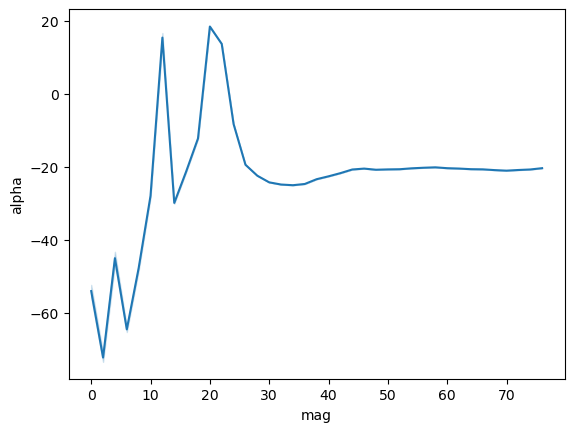

In [66]:
sns.lineplot(data=DF1,x='mag',y='alpha')

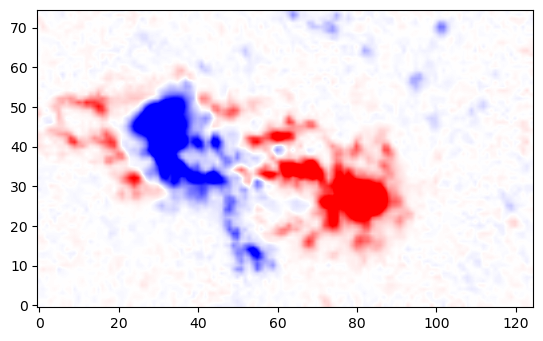

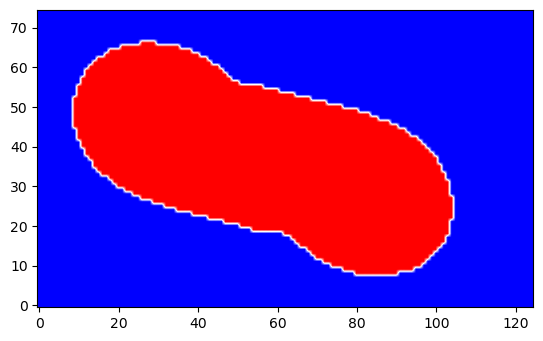

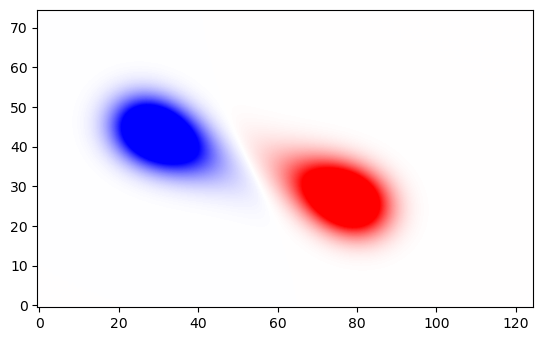

In [73]:
i=50
plt.imshow(data2[:,:,i],origin='lower',interpolation='bilinear',cmap='bwr',vmin=-500,vmax=500)
plt.show()
plt.imshow(mask[:,:,i],origin='lower',interpolation='bilinear',cmap='bwr')
plt.show()
plt.imshow(model[:,:,round(i/2)],origin='lower',interpolation='bilinear',cmap='bwr',vmin=-500,vmax=500)
plt.show()

In [79]:
# Main processing loop
for name in ['8628']:
    try:
        trace = process_dataset(name)
        #DF.append(DF0)
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")
        continue

8628-----------------------------------------------------


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, Con

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52997 seconds.
/home/mpoisson/anaconda3/envs/pymc4/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [76]:
trace = process_dataset(name)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
rango={}
table=pd.read_csv(f'./masks2/{name}_0.csv')[:nmax+1]
for k in table.keys()[1:3]:
    rango[k]=table[k].values[::2]

for k in table.keys()[5:]:
    rango[k]=table[k].mean()

In [ ]:
0.05*rango['axf']

In [68]:
print(name + '-----------------------------------------------------')
datad = np.transpose(np.load(f'../newdat/{name}_cube_data.npy'),axes=(1,2,0))
mask= np.load(f'./masks2/mask_{name}.npy')
data2=datad*mask
f=np.sum(np.abs(data2),axis=(1,0))
nmax=round((np.argmax(f)+len(f))/2)
data2=data2[:,:,:nmax+1]
data2=data2[:,:,::2]

sz2, sz1, nMagnetograms = np.shape(data2)
pixsize = 1.98*725*1000*100
pixarea = pixsize*pixsize

ranges = set_ranges(data2)
hem = ranges['hem']

rango={}
table=pd.read_csv(f'./masks2/{name}_0.csv')[:nmax+1]
for k in table.keys()[1:3]:
    rango[k]=table[k].values[::2]

for k in table.keys()[5:]:
    rango[k]=table[k].mean()
    
bb = [barys(np.abs(data2[:,:,i]), 0) for i in range(nMagnetograms)]
xc2 = [bb[i][0] for i in range(nMagnetograms)]
yc2 = [bb[i][1] for i in range(nMagnetograms)]



mmask=np.zeros_like(data2)
for i in range(nMagnetograms):
    mmask[:,:,i]=np.sum(mask,axis=2)>0

apa = np.ravel(data2)
apamask = np.ravel(mmask)

ind = (pd.Series(np.abs(apamask) > 0)).to_numpy().nonzero()

8016-----------------------------------------------------


/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:85: RuntimeWarning: invalid value encountered in scalar divide
  xn=np.sum(xv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])
/home/mpoisson/Work/ARSFIT/stats-tilt/../funciones/func4.py:88: RuntimeWarning: invalid value encountered in scalar divide
  yn=np.sum(yv[data<-thr]*data[data<-thr])/np.sum(data[data<-thr])


In [69]:
rango

{'da': array([0.07508828, 0.08775832, 0.10042835, 0.11309839, 0.12576843,
        0.13843847, 0.15110851, 0.16377854, 0.17644858, 0.18911862,
        0.20178866, 0.2144587 , 0.22712873, 0.23979877, 0.25246881,
        0.26513885, 0.27780888, 0.29047892, 0.30314896, 0.315819  ,
        0.32848904, 0.34115907, 0.35382911]),
 'alpha': array([-0.20049367, -0.19159747, -0.18270126, -0.17380506, -0.16490885,
        -0.15601265, -0.14711644, -0.13822024, -0.12932403, -0.12042782,
        -0.11153162, -0.10263541, -0.09373921, -0.084843  , -0.0759468 ,
        -0.06705059, -0.05815439, -0.04925818, -0.04036198, -0.03146577,
        -0.02256956, -0.01367336, -0.00477715]),
 'a': 4.086890637519298,
 'R': 28.465481442337,
 'N0': 0.330189564100435,
 'axf': 79499.02195226194,
 'mag': 22.0,
 'AR': 8016.0,
 'lead': 1.0,
 'sig': 163.58154614285752}

In [ ]:
for k in table.keys()[1:3]:
    rango[k]=table[k].values[::2]

for k in table.keys()[5:9]:
    rango[k]=table[k].mean()

In [ ]:
rango

In [87]:
DF0=pd.read_csv('./posteriors3/8628_TM3.csv')

<AxesSubplot: xlabel='alpha', ylabel='Density'>

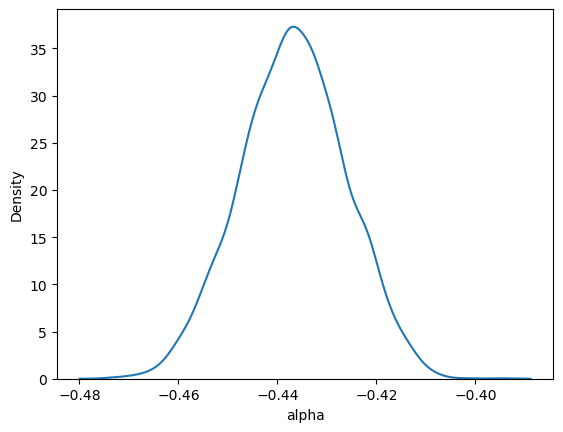

In [102]:
sns.kdeplot(data=DF0[DF0.mag==32],x='alpha')

In [83]:
DF0=DF0.groupby('mag').mean().reset_index()

In [85]:
DF0['alpha']=DF0['alpha'].apply(lambda x:-180*x/np.pi)

<AxesSubplot: xlabel='mag', ylabel='alpha'>

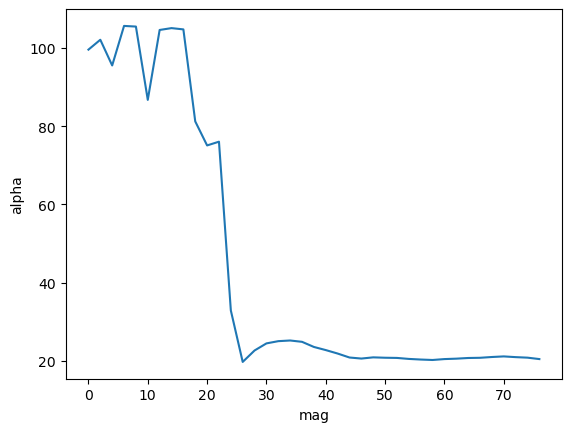

In [86]:
sns.lineplot(data=DF0,x='mag',y='alpha')